<a href="https://colab.research.google.com/github/rivaelsagala/project-PM-kel-05/blob/main/ModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/rivaelsagala/project-PM-kel-05.git


In [1]:
import os
print(os.listdir("dataset/train/"))


['mujahir', 'red_devil', 'sepat']


## Membuat Classifier nya


In [2]:
import tensorflow as tf

In [3]:
# Parameter input untuk network
dim = (640, 640)          
channel = (3, )            
input_shape = dim + channel
# Batch size
batch_size = 8       
# Epoch
epoch = 10                 


## Membuat dataset generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mendefinisikan Data |Generatornya

In [5]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)





## Mendefinisikan asal folder sumber file berasal

In [6]:
# Load data
train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/valid/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)



# Number of classes
num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

print(f"Classes: {labels}")
print(f"Number of classes: {num_class}")

Found 3570 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Found 173 images belonging to 3 classes.
Classes: dict_keys(['mujahir', 'red_devil', 'sepat'])
Number of classes: 3


In [7]:
print(labels)

dict_keys(['mujahir', 'red_devil', 'sepat'])


## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [8]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_class), dtype=tf.float32)
        )
    )
    return tf_generator

In [9]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

## Verifikasi Dataset

In [10]:
for data, labels in train_data.take(1):  # Ambil satu batch
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)

Data shape: (8, 640, 640, 3)
Labels shape: (8, 3)


## Membuat Struktur CNN

## Manualy define network

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisikan model
model = Sequential()
model.add(Input(shape=input_shape))  # Layer input
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implementasi Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



Compiling Model.......


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 640, 640, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 640, 640, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 638, 638, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 638, 638, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 319, 319, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 319, 319, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 319, 319, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 319, 319, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 317, 317, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 317, 317, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 158, 158, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 158, 158, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1597696)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   409,010,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,086,883 (1.52 GB)

 Trainable params: 409,086,883 (1.52 GB)

 Non-trainable params: 0 (0.00 B)

## Using Pre-trained model / Transfer Learning

## Prebuild model

## Build Base Model

In [16]:
from tensorflow.keras.applications import MobileNetV2

# get base models
input_shape = (640, 640, 3)
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class
)


C:\Users\M S I\AppData\Local\Temp\ipykernel_24672\972264181.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


## Add top layer network

In [17]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [18]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# model.summary()

In [19]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Effinet

In [20]:
pip install efficientnet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from efficientnet.tfkeras import EfficientNetB1

## Prebuild model

## Build Base model

In [22]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

## Add top network layer to models

In [23]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [24]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
#model.summary()

In [25]:

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Visualize The final model


In [26]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
pip install netron

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import tensorflow as tf

In [29]:
# import tensorflow as tf
# import visualkeras
# import netron

# # ... (Your model definition) ...

# # Option 1: Using visualkeras
# visualkeras.layered_view(model, to_file='model_visualkeras.png').show() # display the image

# # # Option 2: Using netron
# model.save('project-PM-kel-05/model.h5')
# netron.start('project-PM-kel-05/model.h5')

In [30]:
# model_viz = tf.keras.utils.plot_model(model,
#                           to_file='model.png',
#                           show_shapes=True,
#                           show_layer_names=True,
#                           rankdir='TB',
#                           expand_nested=True,
#                           dpi=55)
# model_viz

In [31]:
# pip install pydot

## Train Model

In [2]:
epochs = 2

In [4]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

NameError: name 'model' is not defined

In [ ]:
history.history['loss']

[0.218908429145813,
 0.13572220504283905,
 0.18987415730953217,
 0.15824995934963226,
 0.13683849573135376,
 0.06074804440140724,
 0.07921381294727325,
 0.05043156072497368,
 0.06372079253196716,
 0.07597362250089645]

In [ ]:
history.history['accuracy']

[0.9434276223182678,
 0.9667221307754517,
 0.9467554092407227,
 0.9484192728996277,
 0.9633943438529968,
 0.9767054915428162,
 0.9750415682792664,
 0.9900166392326355,
 0.981697142124176,
 0.980033278465271]

## Plot the training

In [ ]:
from matplotlib import pyplot as plt

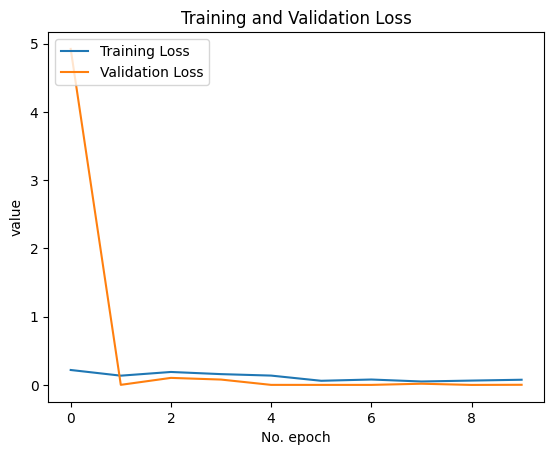

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

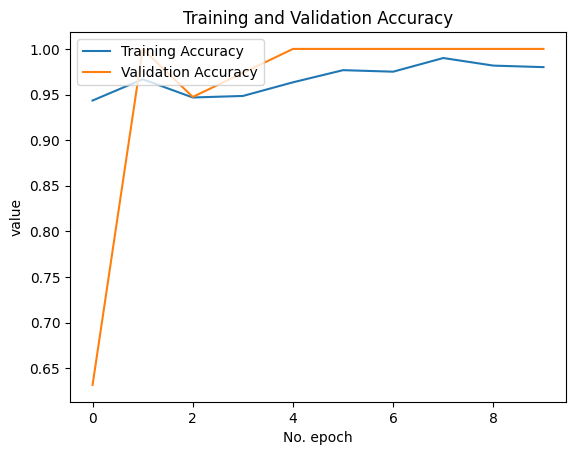

In [ ]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Save Model

In [ ]:
import os

In [ ]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "fish_project"
SAVE_MODEL_NAME = "model.keras"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path)

Saving Model At model\fish_project\model.keras...


In [ ]:
import os
print("Current working directory:", os.getcwd())
print("Files in the current directory:", os.listdir())


Current working directory: c:\Users\M S I\PM\Project-PM\project-PM-kel-05
Files in the current directory: ['.git', '.ipynb_checkpoints', 'best_model.keras', 'dataset', 'Jurnal', 'model', 'model.png', 'ModelTrain.ipynb', 'model_visualkeras.png', 'new_data', 'Original_dataset', 'PredictFunction.ipynb', 'SplitDataset.ipynb']


## Evaluate Models

In [ ]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 1.0000 
Loss on training data: 0.0059 



UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: 'dataset/test/mujahir\\image.jpg'
Traceback (most recent call last):

  File "c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 112, in __next__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\image_utils.py", line 235, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/test/mujahir\\image.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_348469]

In [ ]:
import requests
from io import BytesIO


from PIL import Image
import numpy as np

In [ ]:
# Parameters
input_size = (224,224)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['mujahir', 'red_devil', 'sepat']

In [ ]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
MODEL_PATH = 'model/fish_project/model.keras'
model = load_model(MODEL_PATH,compile=False)

In [ ]:
# read image
im = Image.open('dataset/test/sepat/Sepat-37_png.rf.1713aff88f8f62d6910b073cd5ebd07e.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
sepat 0.99998736


In [ ]:
# read image
im = Image.open('dataset/test/red_devil/Red-Devil-174_jpg.rf.1087bd37678ae295e60fc70e8bfe3a04.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
red_devil 0.9957628


In [ ]:
# read image
im = Image.open('dataset/test/mujahir/Mujahir-171_jpg.rf.78abf75d3b411e183bd6158ab3f11d06.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
mujahir 0.99999976
